In [7]:
%run modulo-adder.ipynb

done


In [42]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import QFT
from math import log, ceil, floor, pi

def c_mod_mul(a, N, n_x_qubits, n_b_qubits):
    c_mod_mul_circ = QuantumCircuit(
        QuantumRegister(1, name="control"),
        QuantumRegister(n_x_qubits, name="x"),
        QuantumRegister(n_b_qubits, name="b"),
        QuantumRegister(1, name="ancilla")
    )
    c_mod_mul_circ.append(
        QFT(n_b_qubits, do_swaps=False).to_gate(), 
        [i + n_x_qubits + 1 for i in range(n_b_qubits)]
    )
    for i in range(n_x_qubits):
        allocs = [i + n_x_qubits + 1 + 1 - 3 for i in range(n_b_qubits+3)]
        allocs[0] = 0
        allocs[1] = i + 1 
        c_mod_mul_circ.append(
            c2_qft_mod_adder(a, N, n_b_qubits).to_gate(label=f"\Phi ADD(2^{i}\cdot {a})MOD({N}))"),
            allocs
        )
    c_mod_mul_circ.append(
        QFT(n_b_qubits, do_swaps=False, inverse=True).to_gate(), 
        [i + n_x_qubits + 1 for i in range(n_b_qubits)]
    )
    
    return c_mod_mul_circ

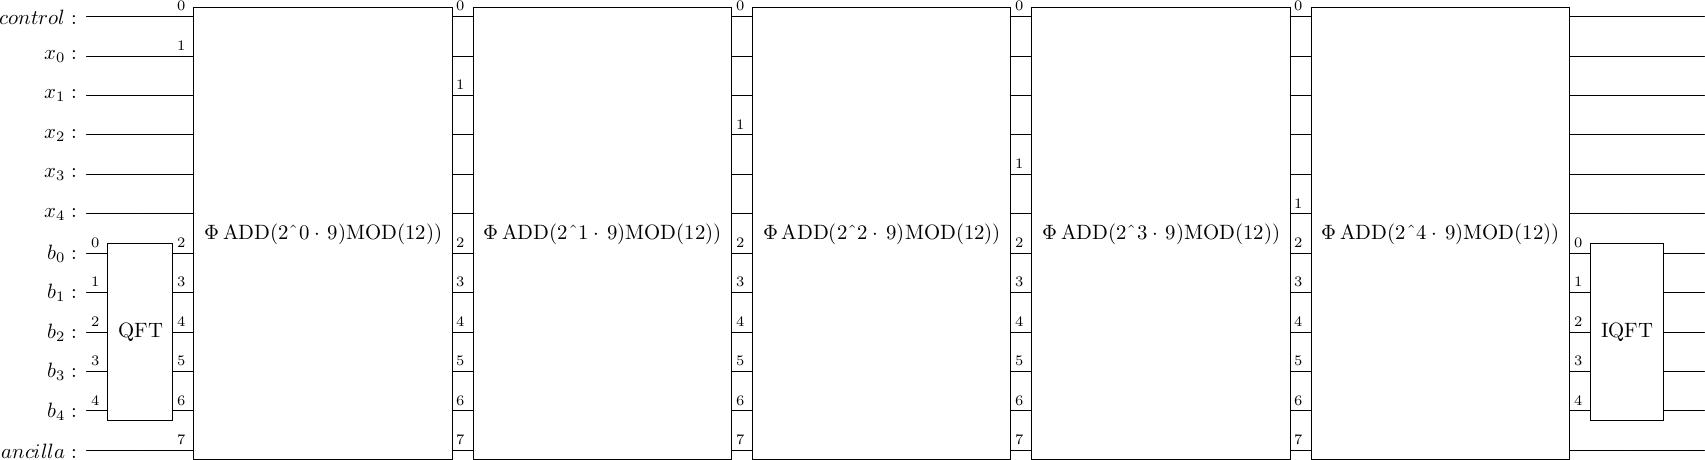

In [44]:
a = 9
x = 6
b = 7
N = 12
n_b_qubits = floor(log(N, 2)) + 2
n_x_qubits = n_b_qubits
c_mod_mul(a, N, n_x_qubits, n_b_qubits).draw("latex")

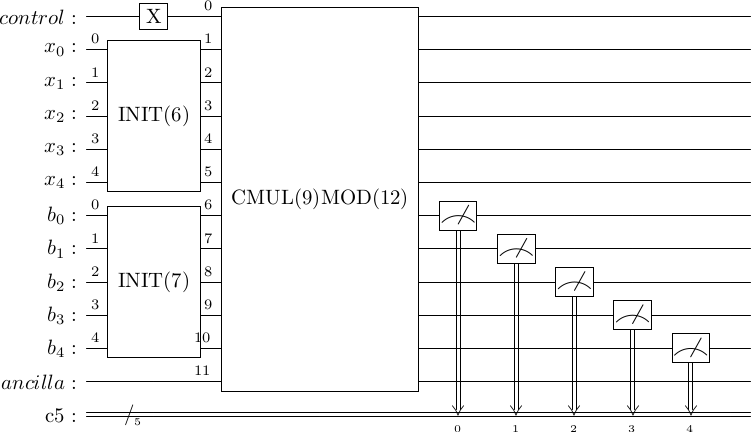

In [57]:
a = 9
x = 6
b = 7
N = 12
n_b_qubits = floor(log(N, 2)) + 2
n_x_qubits = n_b_qubits

test_circuit = QuantumCircuit(
    QuantumRegister(1, name="control"),
    QuantumRegister(n_x_qubits, name="x"),
    QuantumRegister(n_b_qubits, name="b"),
    QuantumRegister(1, name="ancilla"),
    ClassicalRegister(n_b_qubits)
)
test_circuit.x(0)
test_circuit.append(
    init_x_circuit(x, n_x_qubits, msb_top=False).to_gate(label=f"INIT({x})"), 
    [i + 1 for i in range(n_x_qubits)]
)
test_circuit.append(
    init_x_circuit(b, n_b_qubits, msb_top=False).to_gate(label=f"INIT({b})"),
    [i + 1 + n_x_qubits for i in range(n_b_qubits)]
)
test_circuit.append(
    c_mod_mul(a, N, n_x_qubits, n_b_qubits).to_gate(label=f"CMUL({a})MOD({N})"),
    range(1 + n_x_qubits + n_b_qubits + 1)
)
test_circuit.measure(range(1 + n_x_qubits , 1 + n_x_qubits + n_b_qubits), range(n_b_qubits))
test_circuit.draw("latex")

In [58]:
from qiskit.providers.aer import QasmSimulator
from qiskit import transpile

""" Simulation """
# Create a simulator
simulator = QasmSimulator()
# Compile the circuit for the simulator
compiled_circuit = transpile(test_circuit, simulator)
# Simulate the circuit
simulation = simulator.run(compiled_circuit, shots=10000)
# Get the simulation results
simulation_result = simulation.result()
counts = simulation_result.get_counts(compiled_circuit)
counts

{'00001': 10000}